In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [82]:
bank = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [83]:
print(bank.shape)
bank.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [159]:
df, df_test = train_test_split(bank) # splitting the data initially to remove bias.

In [86]:
print(df.shape, df_test.shape)

(30891, 21) (10297, 21)


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30891 entries, 39913 to 32200
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30891 non-null  int64  
 1   job             30891 non-null  object 
 2   marital         30891 non-null  object 
 3   education       30891 non-null  object 
 4   default         30891 non-null  object 
 5   housing         30891 non-null  object 
 6   loan            30891 non-null  object 
 7   contact         30891 non-null  object 
 8   month           30891 non-null  object 
 9   day_of_week     30891 non-null  object 
 10  duration        30891 non-null  int64  
 11  campaign        30891 non-null  int64  
 12  pdays           30891 non-null  int64  
 13  previous        30891 non-null  int64  
 14  poutcome        30891 non-null  object 
 15  emp.var.rate    30891 non-null  float64
 16  cons.price.idx  30891 non-null  float64
 17  cons.conf.idx   30891 non-n

In [88]:
cat_columns = df.select_dtypes(include=object).columns
num_columns = df.select_dtypes(exclude=object).columns
drop_columns = [] # if we need to drop any column

In [89]:
len(cat_columns)

11

In [90]:
for column in cat_columns:
    print(column)
    print(df[column].value_counts())
    print()

job
admin.           7780
blue-collar      6880
technician       5095
services         2975
management       2211
retired          1326
entrepreneur     1096
self-employed    1061
housemaid         791
unemployed        773
student           658
unknown           245
Name: job, dtype: int64

marital
married     18712
single       8639
divorced     3483
unknown        57
Name: marital, dtype: int64

education
university.degree      9118
high.school            7165
basic.9y               4487
professional.course    3963
basic.4y               3132
basic.6y               1724
unknown                1289
illiterate               13
Name: education, dtype: int64

default
no         24460
unknown     6429
yes            2
Name: default, dtype: int64

housing
yes        16127
no         14011
unknown      753
Name: housing, dtype: int64

loan
no         25459
yes         4679
unknown      753
Name: loan, dtype: int64

contact
cellular     19614
telephone    11277
Name: contact, dtype: int64



before removing any columns, lets check if there is any significance of the feature with our target variable.

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>],
       [<AxesSubplot: title={'center': 'pdays'}>,
        <AxesSubplot: title={'center': 'previous'}>,
        <AxesSubplot: title={'center': 'emp.var.rate'}>],
       [<AxesSubplot: title={'center': 'cons.price.idx'}>,
        <AxesSubplot: title={'center': 'cons.conf.idx'}>,
        <AxesSubplot: title={'center': 'euribor3m'}>],
       [<AxesSubplot: title={'center': 'nr.employed'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

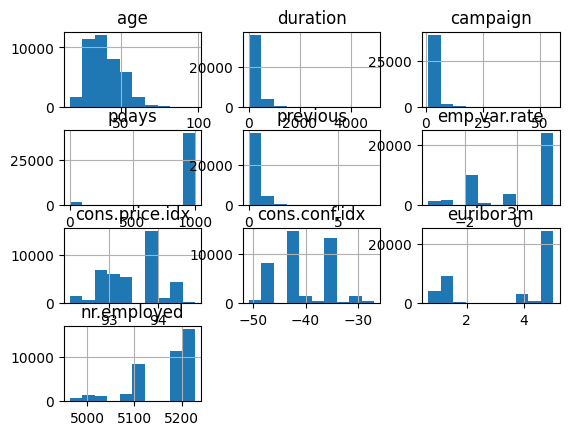

In [91]:
bank.hist()

<AxesSubplot: >

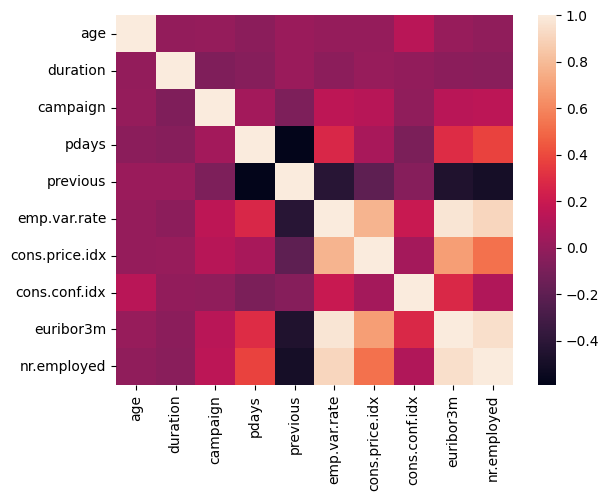

In [92]:
sns.heatmap(df[num_columns].corr())

3 columns i.e euribor3m, nr.employed, emp.var.rate are highly correlated, we can drop 2 of these 3. we will drop the ones, with least statistical significance.

In [93]:
num_columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

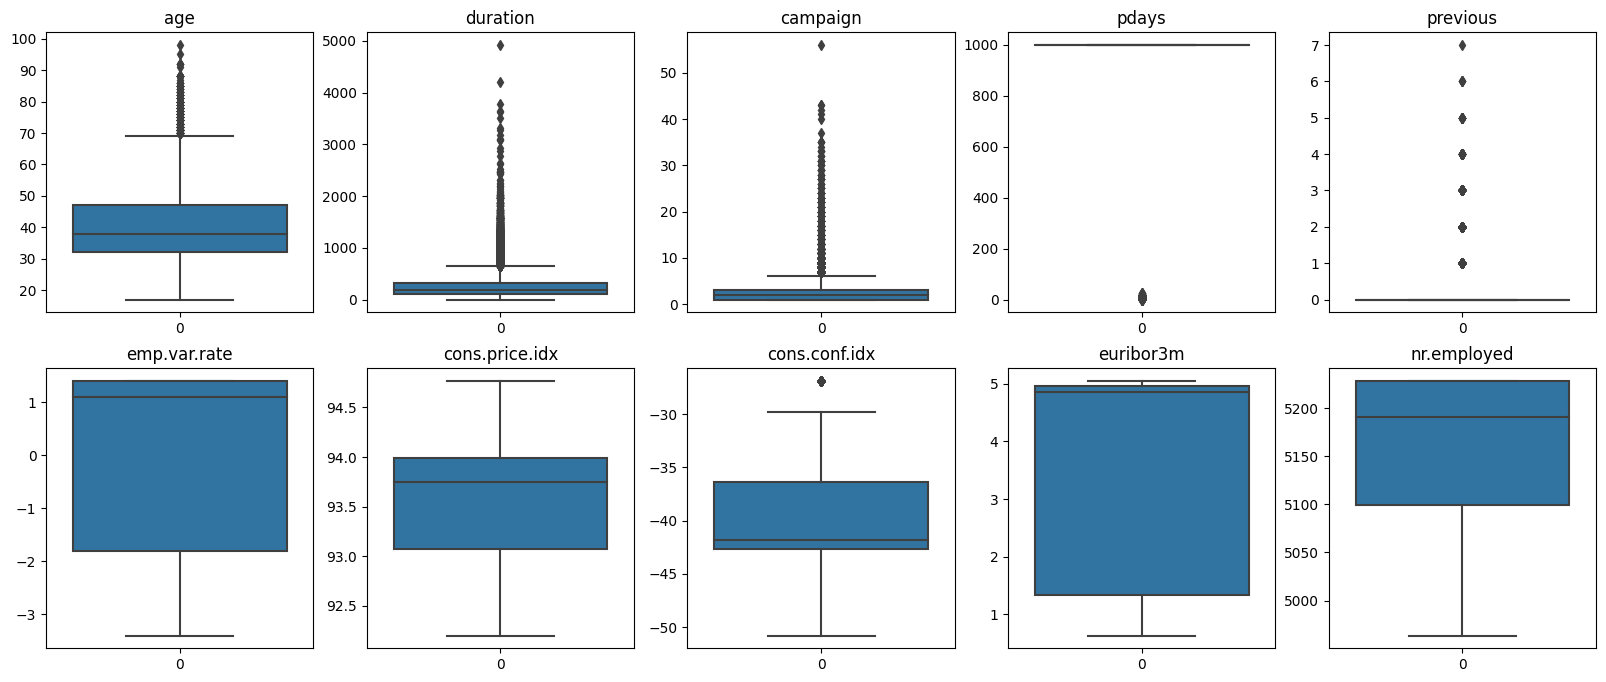

In [95]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, column in enumerate(num_columns):
    sns.boxplot(df[column], ax=axes[i])
    axes[i].set_title(column)
plt.show()

here we observe age, duration, campaign have outliers

In [99]:
dup_rows = df[df.duplicated()]
dup_rows

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
38281,71,retired,single,university.degree,no,no,no,telephone,oct,tue,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no


In [100]:
df[df['y'] == 'yes']['duration'].describe()

count    3446.000000
mean      552.630006
std       402.991984
min        37.000000
25%       252.000000
50%       449.000000
75%       745.000000
max      4199.000000
Name: duration, dtype: float64

In [101]:
df[df['y'] == 'no']['duration'].describe()

count    27445.000000
mean       221.183458
std        206.737363
min          0.000000
25%         95.000000
50%        164.000000
75%        279.000000
max       4918.000000
Name: duration, dtype: float64

In [102]:
df[df['y'] == 'yes']['age'].describe()

count    3446.000000
mean       40.906558
std        13.711139
min        17.000000
25%        31.000000
50%        37.000000
75%        50.000000
max        98.000000
Name: age, dtype: float64

In [103]:
df[df['y'] == 'no']['age'].describe()

count    27445.000000
mean        39.913901
std          9.896369
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         95.000000
Name: age, dtype: float64

In [104]:
df['duration'].value_counts().sort_index()

0        3
1        2
2        1
3        3
4       11
        ..
3631     1
3643     1
3785     1
4199     1
4918     1
Name: duration, Length: 1444, dtype: int64

12 duplicate entries

In [105]:
df.drop_duplicates(inplace=True)
df.shape

(30884, 21)

In [196]:
df['y'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)

# Statistical Tests

In [107]:
cat_cols = df.drop(['y'], axis = 1).select_dtypes(include = object).columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [108]:
num_cols = df.select_dtypes(exclude = object).columns
num_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Categorical

In [110]:
from scipy.stats import chi2_contingency

significant_columns = []
for column in cat_cols:
    contigency = pd.crosstab(df['y'], df[column])
    contigency
    c, p, dof, exp = chi2_contingency(contigency)
    if p < .05:
        significant_columns.append(column)
    print(column, p)

job 2.71795576184282e-141
marital 2.600216156573639e-17
education 4.360049242459897e-26
default 1.091823781885254e-62
housing 0.2535219706728499
loan 0.40687095081937075
contact 1.66598279560464e-136
month 0.0
day_of_week 0.0002602594661077443
poutcome 0.0


here we observe loan and housing are not showing any significant relation with our response variable, so we can drop those.

In [111]:
drop_columns.append('loan')
drop_columns.append('housing')


In [112]:
drop_columns

['loan', 'housing']

### Numerical

In [113]:
from scipy.stats import ttest_ind

In [114]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
39913,35,technician,divorced,professional.course,no,no,no,cellular,jun,wed,...,1,13,2,failure,-1.7,94.055,-39.8,0.739,4991.6,0
14402,36,blue-collar,married,basic.9y,no,unknown,unknown,telephone,jul,mon,...,14,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
9605,27,technician,single,professional.course,no,yes,yes,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0
26363,45,management,married,professional.course,no,no,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,1
25901,48,admin.,married,university.degree,no,no,no,cellular,nov,wed,...,7,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0


In [116]:
significant_n_columns = []
for column in num_cols:
    t_statistic, p_value = ttest_ind(df[df['y'] == 0][column], df[df['y'] == 1][column])
    if p_value < 0.05:
        significant_n_columns.append(column)
    print(column, p_value, t_statistic)

age 1.2135757292666085e-07 -5.292681611054654
duration 0.0 -77.4241763781585
campaign 8.722610254057143e-33 11.939275657855646
pdays 0.0 60.20907947882295
previous 0.0 -42.020898796041386
emp.var.rate 0.0 54.35469223359367
cons.price.idx 7.142823965294685e-120 23.382253842575267
cons.conf.idx 7.36337578429482e-23 -9.850602695071037
euribor3m 0.0 56.113512468014285
nr.employed 0.0 66.3334043610021
y 0.0 -inf


/var/folders/xg/z0bh966j5g78lvgdf6cp59m40000gn/T/ipykernel_36823/3442692265.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(df[df['y'] == 0][column], df[df['y'] == 1][column])


all columns looks significant,
since the t_statistic of nr.employed is greater than emp.var.rate and euribor3m, so we can drop those and keep nr.employed

In [117]:
drop_columns.append('emp.var.rate')
drop_columns.append('euribor3m')

#### lets test with linear regression as well

In [118]:
x = df.copy()

In [119]:
import statsmodels.api as sm

# Fit the linear regression model (using statsmodel since sklearn doesn't provide p-values)
model = sm.OLS(x['y'], x[num_columns]).fit()

coefficients = model.params
p_values = model.pvalues
feature_names = x[num_columns].columns


In [121]:
results = pd.DataFrame({
    'Coefficient': coefficients,
    'P-value': p_values
})

print(results)

                Coefficient        P-value
age                0.000281   5.005901e-02
duration           0.000465   0.000000e+00
campaign           0.001276   1.891885e-02
pdays             -0.000366  2.589905e-279
previous          -0.026580   2.464721e-11
emp.var.rate      -0.040602   1.070507e-15
cons.price.idx     0.052155  1.423160e-106
cons.conf.idx      0.005419   2.364958e-42
euribor3m          0.007569   1.716028e-01
nr.employed       -0.000842   3.050314e-72


### check if there is any sort of ordering in the categorical column

In [128]:
for column in cat_columns:
    print(df.groupby([column])['y'].mean().sort_values(), '\n')

job
blue-collar      0.069051
services         0.081399
housemaid        0.082174
entrepreneur     0.090328
unknown          0.093878
self-employed    0.101791
technician       0.110348
management       0.112619
admin.           0.126093
unemployed       0.146184
retired          0.246224
student          0.308511
Name: y, dtype: float64 

marital
married     0.101294
divorced    0.102814
single      0.137200
unknown     0.140351
Name: y, dtype: float64 

education
basic.9y               0.078226
basic.6y               0.080093
basic.4y               0.098978
high.school            0.109746
professional.course    0.114336
university.degree      0.134584
unknown                0.137422
illiterate             0.307692
Name: y, dtype: float64 

default
yes        0.000000
unknown    0.052582
no         0.127096
Name: y, dtype: float64 

housing
unknown    0.104914
no         0.108731
yes        0.114364
Name: y, dtype: float64 

loan
unknown    0.104914
yes        0.106647
no         0.11

here we observe that columns as job, marital, education, default, contact, month, day_of_week, poutcome all shows some kind of ordering which kind of implies that we should use Mean Encoding rather than blindly using One Hot Encoding. Although we need to try that as well.

### Binning using Weight of Evidence and Information Value

In [129]:
df['age'].describe()

count    30884.000000
mean        40.023572
std         10.394802
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

In [130]:
labels = ['17-25', '26-35', '36-45','46-60','>60']
cutPoints= [16, 25, 35, 45, 60, 90]
df['Age bracket'] = pd.cut(df['age'], cutPoints, labels = labels)

In [131]:
df_woe = pd.DataFrame(pd.pivot_table(df, index=['y'], values='age', columns=['Age bracket'], aggfunc='count', fill_value=0).T)

In [138]:
df_woe.reset_index(inplace=True)

In [140]:
df_woe.columns

Index(['Age bracket', 0, 1], dtype='object', name='y')

In [141]:
total_yes = df_woe[1].sum()
total_no = df_woe[0].sum()
df_woe['woe'] = np.log( (df_woe[1] / total_yes)  / (df_woe[0] / total_no))
df_woe['IV'] = df_woe['woe'] * ((df_woe[1] / total_yes) - (df_woe[0] / total_no))

In [142]:
df_woe

y,Age bracket,0,1,woe,IV
0,17-25,991,258,0.730012,0.028350
1,26-35,9833,1269,0.028252,0.000290
2,36-45,8841,831,-0.288759,0.023338
3,46-60,7391,789,-0.161485,0.006487
4,>60,379,295,1.825206,0.131217


In [143]:
df_woe['IV'].sum()

0.18968252581059525

we can use this binning as this has an information value of .2, which makes our age bracket a moderate predictor

In [145]:
df[['age','Age bracket']]

,age,Age bracket
39913,35,26-35
14402,36,36-45
9605,27,26-35
26363,45,36-45
25901,48,46-60
...,...,...
30510,33,26-35
32010,43,36-45
4463,44,36-45
5190,48,46-60


# Preprocessing

### Ordinal Encoding

In [ ]:
df['day_of_week'].value_counts()

In [147]:
week_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
df['day_week'] = df['day_of_week'].map(week_map)
df.drop('day_of_week', axis=1, inplace=True)

In [150]:
df['month'].value_counts()

may    10368
jul     5358
aug     4651
jun     3955
nov     3086
apr     1971
oct      535
sep      426
mar      409
dec      125
Name: month, dtype: int64

In [151]:
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct': 10, 'nov': 11, 'dec':12}
df['month_'] = df['month'].map(week_map)
df.drop('month', axis=1, inplace=True)

In [197]:
df.head()

,job,marital,education,default,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,nr.employed,y
34119,admin.,single,high.school,no,cellular,may,wed,698,2,999,1,failure,92.893,-46.2,5099.1,1
27924,admin.,single,high.school,no,cellular,mar,fri,102,1,999,0,nonexistent,92.843,-50.0,5099.1,0
30466,admin.,married,high.school,no,telephone,may,mon,133,1,999,0,nonexistent,92.893,-46.2,5099.1,0
12690,services,divorced,university.degree,no,cellular,jul,mon,407,1,999,0,nonexistent,93.918,-42.7,5228.1,0
34610,blue-collar,single,basic.9y,no,cellular,may,thu,224,4,999,0,nonexistent,92.893,-46.2,5099.1,1


In [ ]:
df['Age bracket'] = df['Age bracket'].astype(object)

In [166]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [172]:
drop_columns.extend('age')

['loan', 'housing', 'emp.var.rate', 'euribor3m', 'y', 'age']

In [176]:
df.drop(drop_columns, axis = 1, inplace=True)

In [187]:
cat_columns = df.drop('y', axis = 1).select_dtypes(include=object).columns
cat_columns

Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'day_of_week', 'poutcome'],
      dtype='object')

In [198]:
df_encoded = pd.get_dummies(df.drop('y', axis = 1), columns= cat_columns)

In [199]:
df.shape

(30891, 16)

In [200]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30891 entries, 34119 to 24117
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration                       30891 non-null  int64  
 1   campaign                       30891 non-null  int64  
 2   pdays                          30891 non-null  int64  
 3   previous                       30891 non-null  int64  
 4   cons.price.idx                 30891 non-null  float64
 5   cons.conf.idx                  30891 non-null  float64
 6   nr.employed                    30891 non-null  float64
 7   job_admin.                     30891 non-null  uint8  
 8   job_blue-collar                30891 non-null  uint8  
 9   job_entrepreneur               30891 non-null  uint8  
 10  job_housemaid                  30891 non-null  uint8  
 11  job_management                 30891 non-null  uint8  
 12  job_retired                    30891 non-n

# Models

In [201]:
#X = df.drop('y', axis = 1)
X = df_encoded
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [202]:
import xgboost as xbg

In [203]:
xgb_clf = xbg.XGBClassifier()

In [204]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [205]:
pre_ = xgb_clf.predict(X_train)
accuracy_score(y_train, pre_)

0.9633262466177039

In [206]:
pre = xgb_clf.predict(X_test)

In [207]:
f1_score(y_test, pre)

0.5896713615023473

In [208]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, pre_)

array([[18109,   212],
       [  547,  1828]])

In [209]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pre)

array([[8693,  373],
       [ 501,  628]])

In [210]:
accuracy_score(y_test, pre)

0.914271701814615

In [211]:
importance = xgb_clf.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Feature ranking:")
for i, (feature, score) in enumerate(sorted_importance):
    print(f"{i+1}. Feature {feature}: {score}")

Feature ranking:
1. Feature nr.employed: 33.33401870727539
2. Feature poutcome_success: 17.174345016479492
3. Feature duration: 7.5595784187316895
4. Feature month_oct: 6.815418243408203
5. Feature cons.conf.idx: 4.7995285987854
6. Feature month_may: 4.143035411834717
7. Feature contact_cellular: 4.04135799407959
8. Feature default_no: 3.4658634662628174
9. Feature pdays: 3.3927688598632812
10. Feature month_apr: 3.3141908645629883
11. Feature poutcome_failure: 3.1002047061920166
12. Feature month_aug: 2.9528470039367676
13. Feature education_unknown: 2.839264154434204
14. Feature cons.price.idx: 2.6954874992370605
15. Feature job_blue-collar: 2.6506497859954834
16. Feature day_of_week_thu: 2.5664148330688477
17. Feature education_basic.6y: 2.5571558475494385
18. Feature month_nov: 2.5511276721954346
19. Feature day_of_week_fri: 2.545450448989868
20. Feature day_of_week_mon: 2.3965792655944824
21. Feature job_retired: 2.379812717437744
22. Feature marital_divorced: 2.308812379837036
23

In [212]:
from sklearn.linear_model import LogisticRegression

In [213]:
lr = LogisticRegression()

In [214]:
lr.fit(X_train, y_train)

/Users/nileshrathi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [215]:
pre_ = lr.predict(X_train)

In [216]:
accuracy_score(y_train, pre_)

0.9086780054116738

In [217]:
pre = lr.predict(X_test)
accuracy_score(y_test, pre)

0.9121137812653262

In [218]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pre)

array([[8842,  224],
       [ 672,  457]])

In [219]:
from sklearn.metrics import recall_score, precision_score

In [220]:
recall_score(y_test, pre)

0.40478299379982285

In [55]:
X = d.drop(['nr.employed', 'euribor3m'], axis = 1)
y = d['nr.employed']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [59]:
X_train

,emp.var.rate
2583,1.1
9408,1.4
28983,-1.8
22711,1.4
30017,-1.8
...,...
6266,1.1
11285,1.4
38169,-3.4
860,1.1
